# Engineering features for a model from train set

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random
from datetime import datetime, timedelta

from copy import deepcopy

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

In [2]:
from statsmodels.graphics import tsaplots

## Import training data

In [24]:
path = 'C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/train_set_2018_01_01_01_2022_09_16_06.csv'
train_set = pd.read_csv(path, index_col=0)
train_set.index = pd.DatetimeIndex(train_set.index)
train_set = train_set

In [25]:
train_set.columns

Index(['hourly_price', 'or_10s', 'or_10ns', 'or_30', 'Hour', 'market_demand',
       'ont_demand', 'Imp', 'Exp', 'Flow', 'Imp.1', 'Exp.1', 'Flow.1', 'Imp.2',
       'Exp.2', 'Flow.2', 'Imp.3', 'Exp.3', 'Flow.3', 'Imp.4', 'Exp.4',
       'Flow.4', 'Imp.5', 'Exp.5', 'Flow.5', 'Imp.6', 'Exp.6', 'Flow.6',
       'Imp.7', 'Exp.7', 'Flow.7', 'Imp.8', 'Exp.8', 'Flow.8', 'Imp.9',
       'Exp.9', 'Flow.9', 'Imp.10', 'Exp.10', 'Flow.10', 'Imp.11', 'Exp.11',
       'Flow.11', 'Imp.12', 'Exp.12', 'Flow.12', 'Imp.13', 'Exp.13', 'Flow.13',
       'Imp.14', 'Exp.14', 'Flow.14', 'Year', 'Month', 'Day', 'max_t', 'min_t',
       'mean_t', 'hdd', 'cdd', 'tot_rain', 'Total Snow (cm)', 'tot_precip',
       'gust_dir', 'gust_speed'],
      dtype='object')

## Time series features and autocorrelation

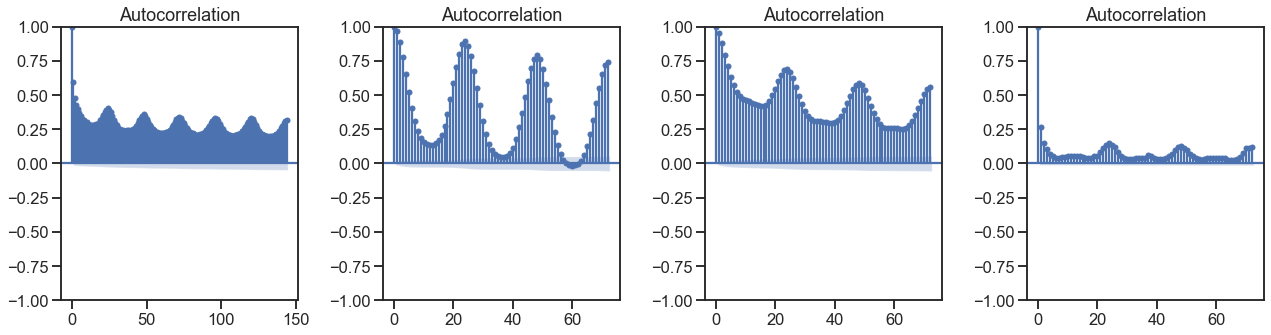

In [39]:
fig, ax = plt.subplots(1,4, figsize=(18,5))
#plot autocorrelation function
tsaplots.plot_acf(train_set['hourly_price'], lags=144, ax=ax[0])
tsaplots.plot_acf(train_set['ont_demand'], lags=72, ax=ax[1])
tsaplots.plot_acf(train_set['Flow.14'], lags=72, ax=ax[2])
tsaplots.plot_acf(train_set['or_10ns'], lags=72, ax=ax[3])

plt.tight_layout()

In [146]:
train_set['hourly_price'].diff()

2018-01-01 01:00:00      NaN
2018-01-01 02:00:00    -7.70
2018-01-01 03:00:00    50.01
2018-01-01 04:00:00   -38.82
2018-01-01 05:00:00   -40.43
                       ...  
2022-09-16 02:00:00    11.85
2022-09-16 03:00:00   -17.61
2022-09-16 04:00:00     0.02
2022-09-16 05:00:00     8.96
2022-09-16 06:00:00    14.89
Name: hourly_price, Length: 41262, dtype: float64

differenced

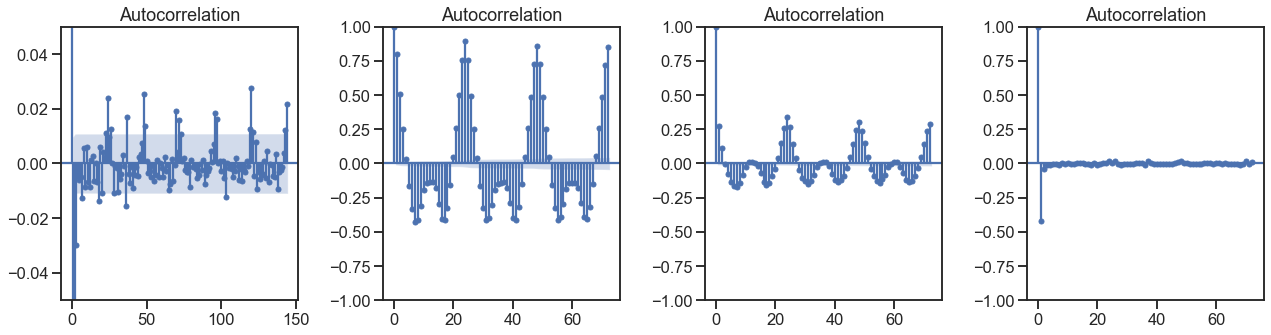

In [155]:
fig, ax = plt.subplots(1,4, figsize=(18,5))
#plot autocorrelation function
tsaplots.plot_acf(train_set['hourly_price'].diff()[1:], lags=144, ax=ax[0])
tsaplots.plot_acf(train_set['ont_demand'].diff(1)[1:], lags=72, ax=ax[1])
tsaplots.plot_acf(train_set['Flow.14'].diff(1)[1:], lags=72, ax=ax[2])
tsaplots.plot_acf(train_set['or_10ns'].diff()[1:], lags=72, ax=ax[3])

ax[0].set_ylim([-0.05,0.05])

plt.tight_layout()

We have some outlier values - my hypothesis is they are related to weather events or outages (but we don't have supply data oh well)

0.3600364156216469

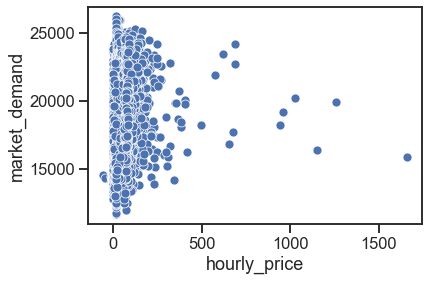

In [78]:
sns.scatterplot(x=train_set['hourly_price'], y=train_set['market_demand'].shift(24))
train_set['hourly_price'].corr(train_set['market_demand'].shift(24))

In [144]:
train_set['hourly_price']#.shift(0)

2018-01-01 01:00:00    51.29
2018-01-01 02:00:00    43.59
2018-01-01 03:00:00    93.60
2018-01-01 04:00:00    54.78
2018-01-01 05:00:00    14.35
                       ...  
2022-09-16 02:00:00    31.98
2022-09-16 03:00:00    14.37
2022-09-16 04:00:00    14.39
2022-09-16 05:00:00    23.35
2022-09-16 06:00:00    38.24
Name: hourly_price, Length: 41262, dtype: float64

In [86]:
def shift_hours_df(col, shift_size):
    shift_df = pd.concat([train_set[col].shift(i) for i in range(shift_size)], axis=1)
    shift_df.columns = [col + str(j) for j in range(shift_size)]

    return shift_df

shift_hours_df('market_demand', 49).head()

,market_demand0,market_demand1,market_demand2,market_demand3,market_demand4,market_demand5,market_demand6,market_demand7,market_demand8,market_demand9,...,market_demand15,market_demand16,market_demand17,market_demand18,market_demand19,market_demand20,market_demand21,market_demand22,market_demand23,market_demand24
2018-01-01 01:00:00,18974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,18447,18974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,18453,18447.0,18974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,18662,18453.0,18447.0,18974.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:00:00,18060,18662.0,18453.0,18447.0,18974.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Heatmap

<AxesSubplot:>

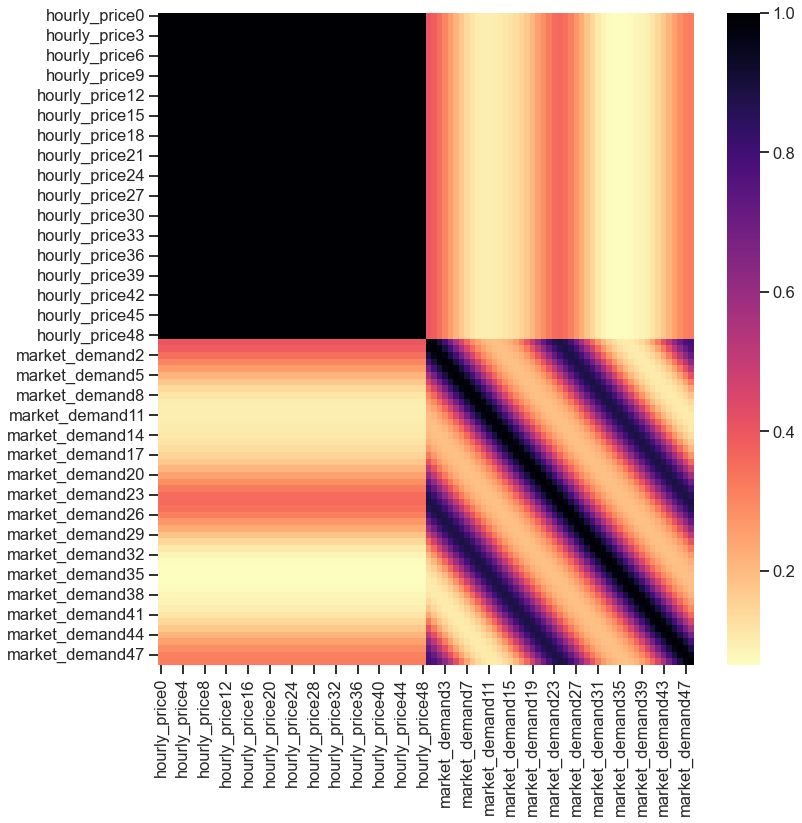

In [97]:
fig, ax = plt.subplots(figsize=(12,12))

price_dup = pd.concat([pd.DataFrame(train_set['hourly_price']).T]*49).T
price_dup.columns = ['hourly_price'+str(i) for i in range(49)]

dem_hm = pd.concat([price_dup, shift_hours_df('market_demand', 49)], axis=1)
sns.heatmap(dem_hm.corr(), ax=ax, cmap='magma_r')

In [183]:
col='hourly_price'
shift_size=49
hrs_ahead = pd.concat([train_set[col].shift(-i) for i in range(shift_size)], axis=1)
hrs_ahead.columns = [col + str(j) for j in range(shift_size)]
hrs_ahead.head()

,hourly_price0,hourly_price1,hourly_price2,hourly_price3,hourly_price4,hourly_price5,hourly_price6,hourly_price7,hourly_price8,hourly_price9,...,hourly_price39,hourly_price40,hourly_price41,hourly_price42,hourly_price43,hourly_price44,hourly_price45,hourly_price46,hourly_price47,hourly_price48
2018-01-01 01:00:00,51.29,43.59,93.60,54.78,14.35,18.60,21.72,40.89,20.75,74.57,...,29.98,42.86,42.33,40.37,42.44,42.29,41.64,8.01,29.72,2.31
2018-01-01 02:00:00,43.59,93.60,54.78,14.35,18.60,21.72,40.89,20.75,74.57,4.65,...,42.86,42.33,40.37,42.44,42.29,41.64,8.01,29.72,2.31,19.43
2018-01-01 03:00:00,93.60,54.78,14.35,18.60,21.72,40.89,20.75,74.57,4.65,9.45,...,42.33,40.37,42.44,42.29,41.64,8.01,29.72,2.31,19.43,0.00
2018-01-01 04:00:00,54.78,14.35,18.60,21.72,40.89,20.75,74.57,4.65,9.45,13.65,...,40.37,42.44,42.29,41.64,8.01,29.72,2.31,19.43,0.00,0.00
2018-01-01 05:00:00,14.35,18.60,21.72,40.89,20.75,74.57,4.65,9.45,13.65,14.37,...,42.44,42.29,41.64,8.01,29.72,2.31,19.43,0.00,0.00,0.00


In [163]:
cols = ['market_demand','ont_demand','Imp.14', 'Exp.14', 'Flow.14','or_10s', 'or_10ns', 'or_30']
hours_ahead_corr = pd.concat([hrs_ahead, train_set[cols]], axis=1)
hours_ahead_corr = hours_ahead_corr.corr()

<AxesSubplot:>

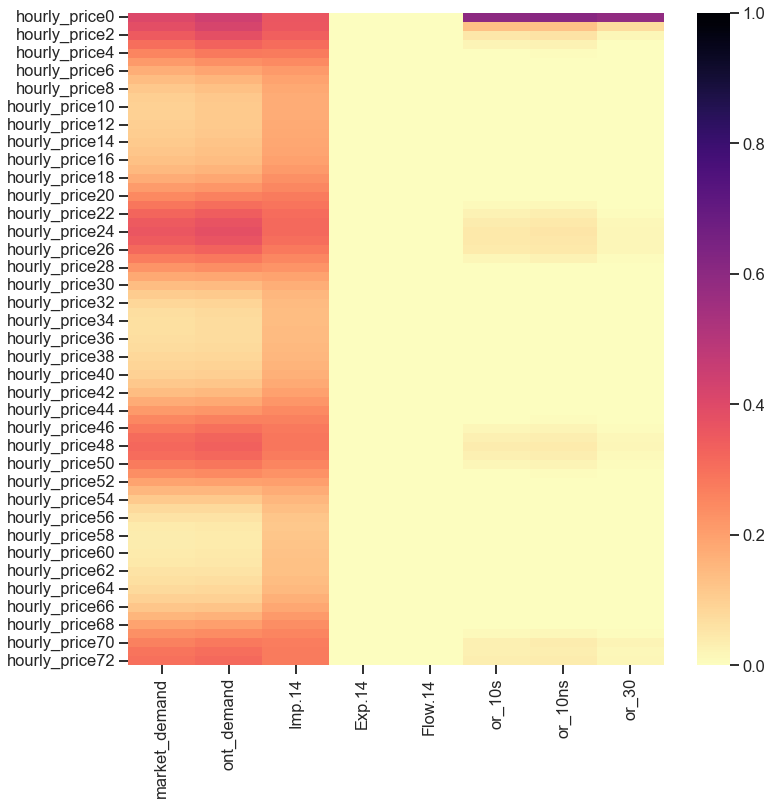

In [164]:
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(hours_ahead_corr.iloc[:73,73:], ax=ax, cmap='magma_r', vmin=0, vmax=1)

differenced

<AxesSubplot:>

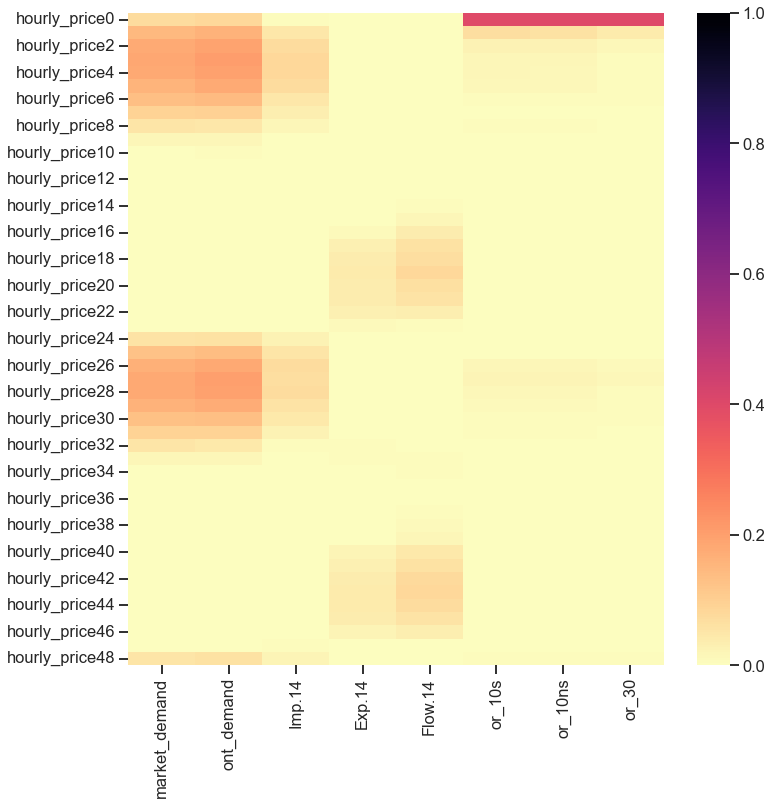

In [161]:
cols = ['market_demand','ont_demand','Imp.14', 'Exp.14', 'Flow.14','or_10s', 'or_10ns', 'or_30']
hours_ahead_corr = pd.concat([hrs_ahead, train_set[cols].diff(1)], axis=1)
hours_ahead_corr = hours_ahead_corr.corr()
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(hours_ahead_corr.iloc[:49,49:], ax=ax, cmap='magma_r', vmin=0, vmax=1)

flow breakdown by location: some are specifically corrolated -> imp.14 (total input), Flow1, various broken down inputs

<AxesSubplot:>

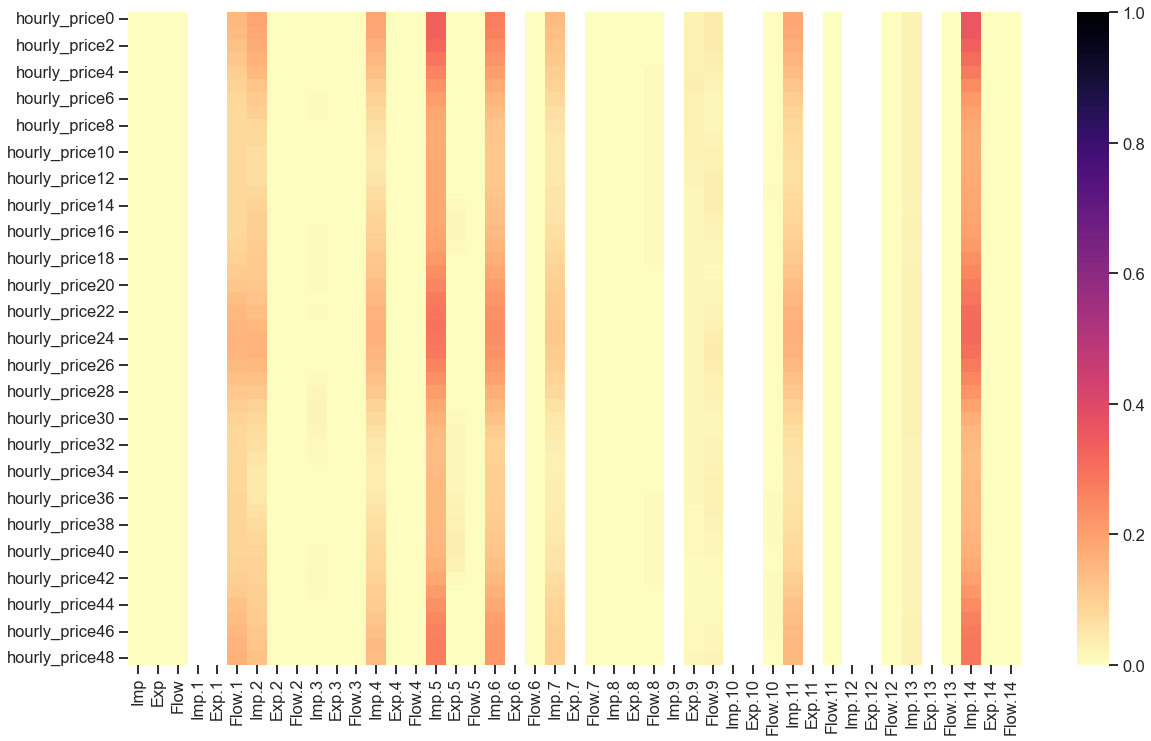

In [185]:
cols_flow = ['Imp', 'Exp', 'Flow', 'Imp.1', 'Exp.1', 'Flow.1', 'Imp.2',
       'Exp.2', 'Flow.2', 'Imp.3', 'Exp.3', 'Flow.3', 'Imp.4', 'Exp.4',
       'Flow.4', 'Imp.5', 'Exp.5', 'Flow.5', 'Imp.6', 'Exp.6', 'Flow.6',
       'Imp.7', 'Exp.7', 'Flow.7', 'Imp.8', 'Exp.8', 'Flow.8', 'Imp.9',
       'Exp.9', 'Flow.9', 'Imp.10', 'Exp.10', 'Flow.10', 'Imp.11', 'Exp.11',
       'Flow.11', 'Imp.12', 'Exp.12', 'Flow.12', 'Imp.13', 'Exp.13', 'Flow.13',
       'Imp.14', 'Exp.14', 'Flow.14',]

hours_ahead_corr_flow = pd.concat([hrs_ahead, train_set[cols_flow]], axis=1)
hours_ahead_corr_flow = hours_ahead_corr_flow.corr()
fig, ax = plt.subplots(figsize=(20,12))

sns.heatmap(hours_ahead_corr_flow.iloc[:49,49:], ax=ax, cmap='magma_r', vmin=0, vmax=1)

## Weather features

### Weather imputation

In [220]:
print(train_set.shape)
train_set.iloc[:,50:].isnull().sum()

(41262, 65)


Exp.14                0
Flow.14               0
Year                  0
Month                 0
Day                   0
max_t               408
min_t               432
mean_t              432
hdd                 432
cdd                 432
tot_rain            336
Total Snow (cm)     288
tot_precip          168
gust_dir           6720
gust_speed         5712
dtype: int64

In [222]:
def input_energyprice_data(data):
    """Imputting temp, CDD/HDD, precip, and wind data"""
    # Temperatures and HDD/CDD imputed using the median of the month
    data_c = data.copy()
    temp_fill_table = data_c.groupby('Month').median()[['max_t','min_t','mean_t','hdd','cdd']]
    for m in range(1,13):
        data_c.loc[data_c['Month'] == m] = data_c.loc[data_c['Month'] == m].fillna({'max_t': temp_fill_table.loc[m,'max_t'],
                                                                                    'min_t': temp_fill_table.loc[m,'min_t'],
                                                                                    'hdd': temp_fill_table.loc[m,'hdd'],
                                                                                    'cdd': temp_fill_table.loc[m,'cdd'],
                                                                                    'mean_t': temp_fill_table.loc[m,'mean_t']})
        
    # precipitation imputed using 
        

    return data_c

In [223]:
testr = input_energyprice_data(train_set)

print(testr.shape)
print(testr.iloc[:,50:].isnull().sum())

(41262, 65)
Exp.14                0
Flow.14               0
Year                  0
Month                 0
Day                   0
max_t                 0
min_t                 0
mean_t                0
hdd                   0
cdd                   0
tot_rain            336
Total Snow (cm)     288
tot_precip          168
gust_dir           6720
gust_speed         5712
dtype: int64


In [201]:
foo = train_set.groupby('Month').median()[['max_t','min_t','hdd','cdd']]
foo.loc[1,'max_t']

-0.2

In [202]:
foo2 = train_set.loc[train_set['Month'] == 1].fillna({'max_t': foo.loc[1,'max_t'],
                                                      'min_t': foo.loc[1,'min_t'],
                                                      'hdd': foo.loc[1,'hdd'],
                                                      'cdd': foo.loc[1,'cdd']})#[['max_t','min_t','hdd','cdd']]
    

foo2

,hourly_price,or_10s,or_10ns,or_30,Hour,market_demand,ont_demand,Imp,Exp,Flow,...,max_t,min_t,mean_t,hdd,cdd,tot_rain,Total Snow (cm),tot_precip,gust_dir,gust_speed
2018-01-01 01:00:00,51.29,0.20,0.20,0.19,1,18974,16627,28,42,16,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 02:00:00,43.59,0.20,0.20,0.20,2,18447,16084,28,0,-20,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 03:00:00,93.60,0.25,0.25,0.22,3,18453,15866,28,0,-26,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 04:00:00,54.78,0.20,0.20,0.20,4,18662,15725,28,0,-36,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 05:00:00,14.35,0.20,0.20,0.20,5,18060,15470,28,42,6,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 19:00:00,54.77,19.20,19.20,0.43,19,22453,20093,0,0,-7,...,-0.9,-7.0,-4.0,22.0,0.0,0.0,0.0,0.0,NaN,NaN
2022-01-31 20:00:00,49.84,13.21,13.21,1.72,20,21895,19388,0,0,1,...,-0.9,-7.0,-4.0,22.0,0.0,0.0,0.0,0.0,NaN,NaN
2022-01-31 21:00:00,51.66,1.10,1.10,1.10,21,21520,18958,0,0,-9,...,-0.9,-7.0,-4.0,22.0,0.0,0.0,0.0,0.0,NaN,NaN
2022-01-31 22:00:00,50.28,0.40,0.40,0.40,22,20452,18047,0,0,-11,...,-0.9,-7.0,-4.0,22.0,0.0,0.0,0.0,0.0,NaN,NaN


In [203]:
foo2.isna().sum()

hourly_price         0
or_10s               0
or_10ns              0
or_30                0
Hour                 0
                  ... 
tot_rain             0
Total Snow (cm)      0
tot_precip           0
gust_dir           600
gust_speed         528
Length: 65, dtype: int64

## Other features